# Predicting if Someone Has Alzheimer's

Hello! In this notebook, I'll be predicting whether someone has Alzheimer's or not based on medical data. I'll be comparing multiple analysis methods (Naïve Bayes, logistic regression, and maybe a probabilistic neural network if I get time) to see how they perform and explaining why they are or aren't a good idea for this dataset. For each method, I'll try one version with all data columns included, and one version with multicollinear data columns removed, so I can see how performance changes when we remove multicollinearity.

This notebook will not focus on data exploration, data cleaning, or encoding methods. If you're interested in that, I've covered the basics in [this notebook](https://github.com/AvilashaHaldar/AJH_Kaggle_Housing_Prices_XGBoost).

Let's get started!

In [1]:
import numpy as np
import pandas as pd
import math
import statistics
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score, roc_curve
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from scipy.stats import norm

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
pd.set_option("future.no_silent_downcasting", True)

/kaggle/input/alzheimers-disease-dataset/alzheimers_disease_data.csv


In [2]:
def calculate_VIF(train_data: pd.DataFrame) -> pd.DataFrame:
    # VIF dataframe 
    X = train_data.astype(float)
    vif_data = pd.DataFrame(index=X.columns, columns=["VIF"])

    # calculating VIF for each feature 
    for i in range(len(X.columns)):
        vif_data.loc[X.columns[i], "VIF"] = variance_inflation_factor(X.values, i)

    return vif_data

# Reading in and processing data

First, we remove the ID column because it's not useful in predicting Alzheimer's. It's just an index. We also remove the confidential column at the end because every entry there is censored, so again, no useful info. 

In [3]:
data = pd.read_csv("/kaggle/input/alzheimers-disease-dataset/alzheimers_disease_data.csv").drop(columns=["PatientID", "DoctorInCharge"])
data.head()

,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
0,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,9.025679,...,6.518877,0,0,1.725883,0,0,0,1,0,0
1,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,7.151293,...,7.118696,0,0,2.592424,0,0,0,0,1,0
2,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,9.673574,...,5.895077,0,0,7.119548,0,1,0,1,0,0
3,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,8.392554,...,8.965106,0,1,6.481226,0,0,0,0,0,0
4,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,5.597238,...,6.045039,0,0,0.014691,0,0,1,1,0,0


The ethnicity column is given in numbers:

- 0: Caucasian
- 1: African American
- 2: Asian
- 3: Other

But any analysis method we use would assume a meaning to the order of numbers, which isn't true, so we'll one-hot-encode these.

We'll also turn any int columns that are only 1s and 0s into bool columns. This will make it easier to divide the data later into ones we can use Naïve Bayes on, and ones we can use Gaussian Naïve Bayes on. We base these decisions on the [data description](https://www.kaggle.com/datasets/rabieelkharoua/alzheimers-disease-dataset/data).

In [4]:
data["Ethnicity"] = data["Ethnicity"].map(pd.Series({0: "Caucasian", 1: "Black", 2: "Asian", 3: "Other"}))

In [5]:
ethnicity_columns = pd.get_dummies(data["Ethnicity"])
data = pd.concat([data.drop(columns=["Ethnicity"]), ethnicity_columns], axis=1)

In [6]:
int_columns_to_make_bool = ["Gender", "Smoking", "FamilyHistoryAlzheimers", "CardiovascularDisease",
                           "Diabetes", "Depression", "HeadInjury", "Hypertension", "MemoryComplaints",
                           "BehavioralProblems", "Confusion", "Disorientation", "Diagnosis",
                           "PersonalityChanges", "DifficultyCompletingTasks", "Forgetfulness"] + ethnicity_columns.columns.tolist()

non_bool_columns = list(set(data.columns) - set(int_columns_to_make_bool))

data = pd.concat([data[non_bool_columns], data[int_columns_to_make_bool].astype(bool)], axis=1)
data.head()

,CholesterolLDL,EducationLevel,ADL,PhysicalActivity,FunctionalAssessment,CholesterolTriglycerides,SystolicBP,SleepQuality,AlcoholConsumption,DietQuality,...,Confusion,Disorientation,Diagnosis,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Asian,Black,Caucasian,Other
0,56.150897,2,1.725883,6.327112,6.518877,162.189143,142,9.025679,13.297218,1.347214,...,False,False,False,False,True,False,False,False,True,False
1,193.407996,0,2.592424,7.619885,7.118696,294.630909,115,7.151293,4.542524,0.518767,...,False,False,False,False,False,True,False,False,True,False
2,153.322762,1,7.119548,7.844988,5.895077,83.638324,99,9.673574,19.555085,1.826335,...,False,True,False,False,True,False,False,False,False,True
3,65.366637,1,6.481226,8.428001,8.965106,277.577358,118,8.392554,12.209266,7.435604,...,False,False,False,False,False,False,False,False,True,False
4,92.869700,0,0.014691,6.310461,6.045039,291.198780,94,5.597238,18.454356,0.795498,...,False,False,False,True,True,False,False,False,True,False


Let's start looking at dtypes and checking for NaNs.

In [7]:
data.dtypes

CholesterolLDL               float64
EducationLevel                 int64
ADL                          float64
PhysicalActivity             float64
FunctionalAssessment         float64
CholesterolTriglycerides     float64
SystolicBP                     int64
SleepQuality                 float64
AlcoholConsumption           float64
DietQuality                  float64
CholesterolTotal             float64
Age                            int64
CholesterolHDL               float64
BMI                          float64
MMSE                         float64
DiastolicBP                    int64
Gender                          bool
Smoking                         bool
FamilyHistoryAlzheimers         bool
CardiovascularDisease           bool
Diabetes                        bool
Depression                      bool
HeadInjury                      bool
Hypertension                    bool
MemoryComplaints                bool
BehavioralProblems              bool
Confusion                       bool
D

In [8]:
# Get the total number of NaNs in the dataset
data.isna().sum().sum()

0

Oh wow. That's a pleasant surprise - everything is numerical (no object columns) and there aren't any NaNs. That makes the data processing part a lot easier.

I'm thinking of starting with Naïve Bayes (note that we'll use the regular Naïve Bayes for any columns that are only 1s and 0s, as Naïve Bayes checks the probability of a feature existing vs the probability of the label being true; we'll use Gaussian Naïve Bayes for numerical features). My concern with this approach is that all Naïve Bayes methods assume independence of all features, and that is simply not true here.

We could use the variance inflation factor to find the highly multicollinear features and get rid of them, but honestly, I'm rather curious to see how much worse Naïve Bayes will do with non-independent features than other methods like logistic regression or a neural network. Since this isn't a competition, there's more space for me to try different things.

I'm going to try Naïve Bayes twice - once with the data as is, and once with highly multicollinear columns removed, just to see what happens.

# About Naïve Bayes

**Naïve Bayes** is a popular classification method due to its simplicity and non-black-box behavior. It's relatively easy to understand compared to many deep learning frameworks (e.g. transformers, long short-term memory) and also doesn't take as much computation or time to train. It's not a method that I expect to perform well on this data though, and I'll explain why in a bit.

## Bayes Theorem

Naïve Bayes is based on **Bayes Theorem**, which is about conditional probability, and tells you the probability of something being true given that something else is already known to be true. The theorem is given below. Note that $P(A|B)$ means probability of $A$ being true if $B$ is true.

$$P(A|B) = \frac{P(B|A)P(A)}{P(B)}$$

Let's consider $A$ to be a given label classification, and $B$ to be a feature. If we assume complete independence of all features, we can also consider $B$ to indicate multiple features being true, like so:

$$B = B_0 \textrm{ and } B_1 \textrm{ and } ... \textrm{ and } B_n \textrm{ all being true}$$

$$P(A|B_0 \,\textrm{and}\, ... B_n\, \textrm{being true}) = \frac{P(\textrm{all} \,B \,\textrm{features being true} | A) \times P(A)}{P(\textrm{all} \,B \,\textrm{features being true})}$$

Assuming independence of features,

$$P(\textrm{all} \,B \,\textrm{features being true}) = P(B_0) \times P(B_1) \times ... \times P(B_n)$$

Now here's the cool part: we can also set any $B_n$ to be an opposite or a false condition. So we could be looking at $P(\textrm{(Smoker) and (no Diabetes)})$.

## Naïve Bayes Types

There are a few different "types" of naïve Bayes used for different data types. The classical **Naïve Bayes** is good for boolean features denoting the existence of something, and we then determine how often the existence of that feature correlates to a certain label value. We've got a lot of bool columns (e.g. Diabetes, which is a boolean telling us if a person has diabetes), so we'll use Naïve Bayes for those.

**Gaussian Naïve Bayes** is for numerical features where we determine the mean and standard deviation of the feature assuming a given label value, and then when given a new number, we determine the likelihood of the feature being that value. I'll include some graphs later to make it clearer.

A concern here is that some of our numerical columns aren't actually normally distributed. The data card I linked earlier has frequency plots at the bottom for each feature, and it's quite clear that some numerical features are uniformly distributed. Because of this, I'm expecting logistic regression to work better than Naïve Bayes, but we'll see.

To start, I'm going to define my own functions for determining Naïve Bayes rather than using the standard sklearn ones. In a production setting, I'd use the sklearn functions, but just as an exercise, I want to try writing the functions myself. We start by defining the columns we want (the boolean ones) and getting the **prior probabilities**, which are the general probability $P(A)$ of a certain label value occurring, where the label values here are True and False diagnoses of Alzheimer's.

We then get the **conditional probabilities** of a feature being true given a certain label value. We also need the general probabilities of each feature, or the chance of a feature being true regardless of the label value.

In [9]:
def implement_full_naive_bayes(data: pd.DataFrame, label_col: str = "Diagnosis"):
    """
    At this point, we assume all columns are either boolean or numerical.
    We will use Naïve Bayes for the boolean columns (classification)
    and Gaussian Naïve Bayes for the numerical columns.
    """
    X = data.drop(columns=[label_col])
    y = data[label_col]
    
    bool_cols = X.dtypes[X.dtypes == bool].index
    gaussian_cols = X.dtypes[X.dtypes != bool].index
    
    unique_classes = y.unique()
    # The total_probabilities (i.e. the general chance of a certain label value occurring)
    # are called the prior probabilities.
    total_probabilities = y.value_counts() / len(y)
    
    # General probabilities for each feature, regardless of label value
    general_probabilities = X[bool_cols].sum() / len(X)
    general_probabilities = pd.concat([general_probabilities, 1-general_probabilities], axis=1)
    general_probabilities.columns = [True, False]
    
    # We calculate conditional probabilities for each unique possible class/output
    conditional_probabilities = pd.DataFrame(columns=unique_classes.tolist(), index=bool_cols.tolist())
    
    # Here, we get the conditional probabilities
    for classification in unique_classes:
        this_df = data[data[label_col] == classification].drop(columns=[label_col])
        boolean_probabilities = this_df[bool_cols].sum(axis=0) / len(this_df)
        conditional_probabilities.loc[bool_cols, classification] = boolean_probabilities
    
    # conditional_probabilities currently has the columns [True, False] for the label values
    # and has the probability of each feature column being true given the label value = [conditional_prob column name]
    # So the True column is the probability that each feature is true given the label is True.
    
    # We then create the equivalent dataframe for the probability that each feature is False.
    conditional_probs_2 = 1-conditional_probabilities
    
    # We then make MultiIndex columns with the first level being the label value and the second level being the feature value.
    conditional_probabilities.columns = pd.MultiIndex.from_tuples(((i, True) for i in conditional_probabilities.columns), names=["LabelValue", "FeatureValue"])
    conditional_probs_2.columns = pd.MultiIndex.from_tuples(((i, False) for i in conditional_probs_2.columns), names=["LabelValue", "FeatureValue"])

    # We combine the conditional probability dataframes so we now have every combo of [label_val, feature_val].
    conditional_probabilities = pd.concat([conditional_probabilities, conditional_probs_2], axis=1)
    
    return conditional_probabilities, total_probabilities, general_probabilities, bool_cols, gaussian_cols

We also need to define how we'll use these values to make new predictions on test_data which does not have the Diagnosis column. 

For classical Naïve Bayes, we will only consider the boolean columns and, for each label value, we get the probability of the feature values being what they are, assuming the label value. This is $P(B|A)$.

We also have $P(A)$ as the total_probabilities and $P(B)$ as the general_probabilities.

One thing we need to be careful about is **underflow**, which is when our values get too close to 0 for our computer to remember the digits correctly. Since we'll be multiplying all the probabilities $P(B_0, B_1, ... B_n)$ together, we could end up with very small values, so we'll be **taking the logs of all probabilities**.

When Naïve Bayes is used for natural language processing (e.g. classifying an email as spam or not), and the probabilities are of the existence of different words, it's important to deal with the case that test data includes words that didn't exist in the training data. This is often done through **Laplace additive smoothing**, or adding a small number to the probabilities of new words to avoid multiplying by 0 probability, or if we're doing log-transforms, then to avoid taking the log of 0.

If any of our conditional probabilities were 0, Laplace smoothing would be necessary. However, we don't have that, and I think it's better to not change the probability values themselves if we don't have to, for accuracy's sake.

In [10]:
def do_naive_bayes_predictions(conditional_probabilities: pd.DataFrame, total_probabilities: pd.Series, general_probabilities: pd.DataFrame, bool_cols: list, test_data: pd.Series) -> pd.Series:
    test_data = test_data[bool_cols]
    naive_bayes_calculations = dict()
    
    test_general_probs = np.log(test_data.copy().replace(general_probabilities.T.to_dict()).astype(float)).sum(axis=1)
    results = pd.DataFrame(index=test_data.index, columns=total_probabilities.index, dtype=float)
    
    for labelval in total_probabilities.index:
        
        # We get the probability of the features being what they are given that the label = labelval
        # We also want to take the log of (P(B0) * P(B1) * ... * P(Bn))
        # which is equivalent to taking the log of each individual probability and then summing the logs
        
        this_cond_prob = np.log(test_data.copy().replace(conditional_probabilities[labelval].T.to_dict()).astype(float))
        
        # We want to multiply P(B|A) by P(A)/P(B). Since we've taken logs, this is just adding and subtracting
        this_cond_prob = this_cond_prob.sum(axis=1) + np.log(total_probabilities[labelval]) - test_general_probs
        results[labelval] = this_cond_prob
    
    return results

In [11]:
def count_categories(test_predictions: pd.Series, test_answers: pd.Series):
    all_results = pd.concat([test_predictions, test_answers], axis=1)
    all_results.columns = ["predictions", "answers"]
    
    true_positives = all_results[(all_results["predictions"] == True) & (all_results["answers"] == True)]
    true_negatives = all_results[(all_results["predictions"] == False) & (all_results["answers"] == False)]
    false_positives = all_results[(all_results["predictions"] == True) & (all_results["answers"] == False)]
    false_negatives = all_results[(all_results["predictions"] == False) & (all_results["answers"] == True)]   
    
    return {"TP": len(true_positives), "TN": len(true_negatives), "FP": len(false_positives), "FN": len(false_negatives)}

def make_confusion_matrix(test_predictions: pd.Series, test_answers: pd.Series):
    all_results = pd.concat([test_predictions, test_answers], axis=1)
    all_results.columns = ["predictions", "answers"]
    
    cm = confusion_matrix(test_answers, test_predictions, normalize='all')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    
    disp.plot()
    plt.show()
    plt.close()
    
def make_ROC_curve(test_predictions: pd.Series, test_answers: pd.Series, label: str=""):
    
    auc = roc_auc_score(test_answers, test_predictions)
    print(f"Area under ROC curve (AUC): {auc}")
    
    false_positive_rate, true_positive_rate, threshold = roc_curve(test_answers, test_predictions)
    plt.title('ROC curve')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    plt.plot(false_positive_rate, true_positive_rate, label=label)
    plt.plot([0, 1], ls="--", label="By Chance")
    plt.legend()
    
    plt.show()
    plt.close()
    
    return auc

Okay, so we've looked at how to get the probabilities needed to do Naïve Bayes calculoations with boolean columns. Now let's look at our numerical columns and check if they're Gaussian. First we plot for the case where Diagnosis is True.

array([[<Axes: title={'center': 'CholesterolLDL'}>,
        <Axes: title={'center': 'EducationLevel'}>,
        <Axes: title={'center': 'ADL'}>,
        <Axes: title={'center': 'PhysicalActivity'}>],
       [<Axes: title={'center': 'FunctionalAssessment'}>,
        <Axes: title={'center': 'CholesterolTriglycerides'}>,
        <Axes: title={'center': 'SystolicBP'}>,
        <Axes: title={'center': 'SleepQuality'}>],
       [<Axes: title={'center': 'AlcoholConsumption'}>,
        <Axes: title={'center': 'DietQuality'}>,
        <Axes: title={'center': 'CholesterolTotal'}>,
        <Axes: title={'center': 'Age'}>],
       [<Axes: title={'center': 'CholesterolHDL'}>,
        <Axes: title={'center': 'BMI'}>,
        <Axes: title={'center': 'MMSE'}>,
        <Axes: title={'center': 'DiastolicBP'}>]], dtype=object)

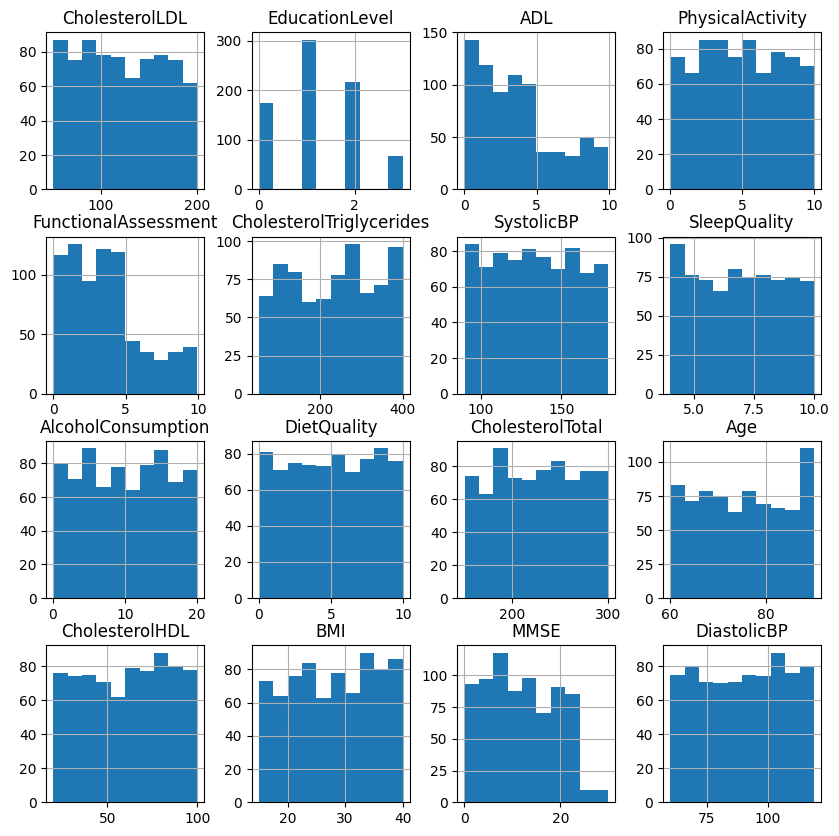

In [12]:
gaussian_cols = data.dtypes[data.dtypes != bool].index
data.loc[data["Diagnosis"] == True][gaussian_cols].hist(figsize=(10,10))

Then we plot for where diagnosis is False.

array([[<Axes: title={'center': 'CholesterolLDL'}>,
        <Axes: title={'center': 'EducationLevel'}>,
        <Axes: title={'center': 'ADL'}>,
        <Axes: title={'center': 'PhysicalActivity'}>],
       [<Axes: title={'center': 'FunctionalAssessment'}>,
        <Axes: title={'center': 'CholesterolTriglycerides'}>,
        <Axes: title={'center': 'SystolicBP'}>,
        <Axes: title={'center': 'SleepQuality'}>],
       [<Axes: title={'center': 'AlcoholConsumption'}>,
        <Axes: title={'center': 'DietQuality'}>,
        <Axes: title={'center': 'CholesterolTotal'}>,
        <Axes: title={'center': 'Age'}>],
       [<Axes: title={'center': 'CholesterolHDL'}>,
        <Axes: title={'center': 'BMI'}>,
        <Axes: title={'center': 'MMSE'}>,
        <Axes: title={'center': 'DiastolicBP'}>]], dtype=object)

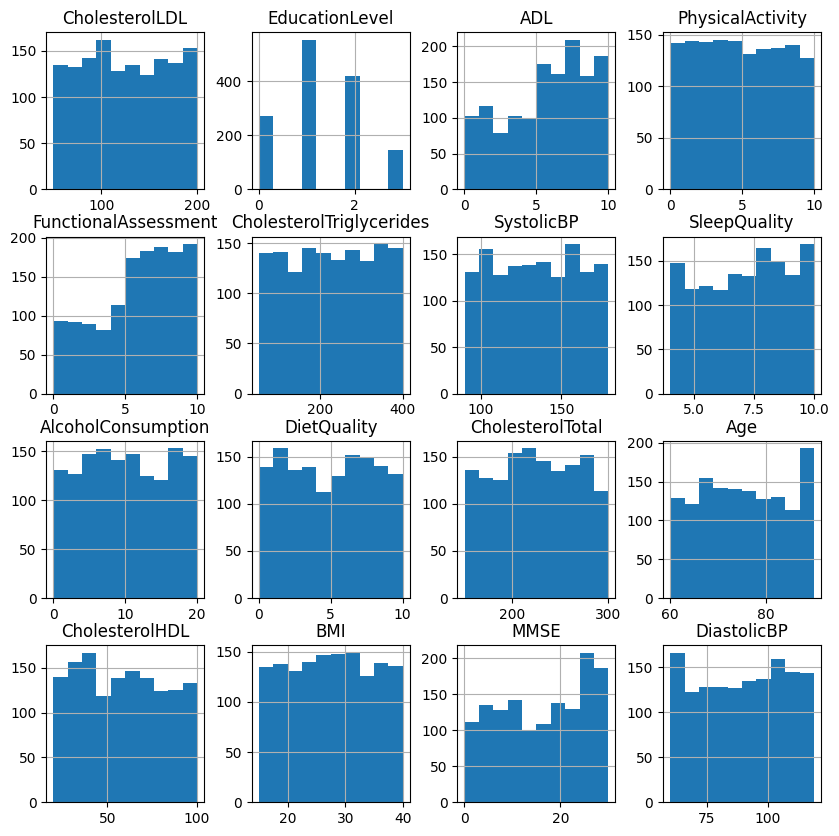

In [13]:
data.loc[data["Diagnosis"] == False][gaussian_cols].hist(figsize=(10,10))

## Why is Nothing Normally Distributed?

Oh boy. Nearly none of these look normally distributed whatsoever. While classical Naïve Bayes does not assume a normal distribution of features, Gaussian Naïve Bayes _does_ assume a normal distribution of features, which is not true for anything here besides EducationLevel. This is the reason why I don't expect Naïve Bayes to do well on this data.

I suspect that the reason why everything looks oddly uniform is because the data has intentionally cut off the tails. Look at the data description of the clinical measurements:

- SystolicBP: Systolic blood pressure, ranging from 90 to 180 mmHg.
- DiastolicBP: Diastolic blood pressure, ranging from 60 to 120 mmHg.
- CholesterolTotal: Total cholesterol levels, ranging from 150 to 300 mg/dL.
- CholesterolLDL: Low-density lipoprotein cholesterol levels, ranging from 50 to 200 mg/dL.
- CholesterolHDL: High-density lipoprotein cholesterol levels, ranging from 20 to 100 mg/dL.
- CholesterolTriglycerides: Triglycerides levels, ranging from 50 to 400 mg/dL.

Now look at the plot from a [research paper](https://www.researchgate.net/figure/Distribution-of-the-low-density-lipoprotein-cholesterol-LDL-C-level-in-34-415-subjects_fig1_231225528) on Cholesterol LDL-C. In the population plot from the paper, the there are values below 50 and above 200 (the cut-offs in the data description) which represent the tails. Same with total cholesterol - [this paper](https://www.researchgate.net/figure/Distribution-of-total-cholesterol-levels-in-study-participants_fig1_51984299) shows total cholesterol values outside the 150-300 range specified in our data. It seems that whoever collected our data either threw out the data from everyone outside the accepted ranges, or simply recorded them as the cut-off values, both of which are wrong.

This is a PSA to _**ALWAYS**_ record your measurements as they truly are, rather than changing the value if they fall outside the expected range, and to not throw out data just because it looks funny.

## So What Now?

If the Alzheimer's data hadn't cut off the tails, we could reasonably use Gaussian Naïve Bayes on the clinical data, but since there's no way for us to retrieve the missing tails, we have a few options. In a production setting, I'd move straight to a logistic regression and not even attempt any form of Naïve Bayes, but since this is a space to explore different options to see how well (or how badly) they work, I'm going to try a few things.

First, I'll try a version where I disregard the numerical data entirely and only use Naïve Bayes on the boolean columns. I'll then try using Gaussian Bayes on the data as-is, despite it being uniformly distributed. This means trying to fit Gaussians to uniform distribution, and seeing how disastrously that goes.

Then will be trying to transform the uniform distributions to normal ones using various transformations (e.g. log, power, Box-Muller). Let's start with the first version, where we only consider the boolean columns:

# Classical Naïve Bayes Only

This is an approach I don't like because we're just throwing out tons of features and useful data. But it'll be interesting to see if we can still get semi-sensible results even when we do that. Let's scramble the order of our data and use **K-fold cross-validation** to train and test our data. I've described K-fold cross-validation in more detail previously [here](https://www.kaggle.com/code/avilashahaldar/housing-prices-with-gradient-boosting-trees).

In [14]:
def classical_naive_bayes(data, n_splits = 10, label_col = "Diagnosis", vif_cutoff=5, remove_multicollinear_cols=False):
    data = data.sample(frac=1).reset_index(drop=True)

    # We train our Naïve Bayes on the training data and test on the testing data, which was not used in training.
    # We do this for each fold and then average all the errors at the end.
    kf = KFold(n_splits=n_splits)
    test_results_dict = dict()
    all_test_answers = []
    all_test_predictions = []

    for fold_num, (train_index, test_index) in enumerate(kf.split(data)):

        train_data = data.loc[train_index]
        test_data = data.loc[test_index].drop(columns=label_col)
        test_data_answers = data.loc[test_index, label_col]
        
        if remove_multicollinear_cols:
            vif_data = calculate_VIF(train_data.astype(int).astype(float))
            cols_to_remove = vif_data.loc[vif_data["VIF"] > vif_cutoff].index.tolist()
            train_data = train_data.drop(columns=cols_to_remove)
            test_data = test_data.drop(columns=cols_to_remove)

        conditional_probabilities, total_probabilities, general_probabilities, bool_cols, gaussian_cols = implement_full_naive_bayes(train_data)
        results = do_naive_bayes_predictions(conditional_probabilities, total_probabilities, general_probabilities, bool_cols, test_data)

        # At this point, we have the final P(A|B) for each row of test data.
        # We get the label value corresponding to the highest probability
        results = results.T.idxmax()
    
        test_results_dict[fold_num] = count_categories(results, test_data_answers)
        all_test_answers.append(test_data_answers)
        all_test_predictions.append(results)

    test_results_dict = pd.DataFrame(test_results_dict).sum(axis=1)
    all_test_answers = pd.concat(all_test_answers)
    all_test_predictions = pd.concat(all_test_predictions)
    
    return test_results_dict, all_test_answers, all_test_predictions

In [15]:
test_results_dict, all_test_answers, all_test_predictions = classical_naive_bayes(data, remove_multicollinear_cols=False)

We've added up the true positives, true negatives, etc. from all the folds' test data predictions. Let's now make a confusion matrix and ROC curve.

A **confusion matrix** tells us the proportion of true positives, true negatives, false positives, and false negatives using a 2x2 grid. If your label can be more than 2 possible categories, you can make a confusion matrix for each category, but we have only 2 categories, so just the one confusion matrix is fine.

An **ROC curve** plots the true positive rate vs the false positive rate. Ideally, we'd have a square; we'd start at the origin and go straight up to (0, 1) and then have a horizontal line across the top, meaning the area under the curve or **AUC** would be 1. If we have a diagonal line from the origin to (1, 1), that means we have an equal number of true and false positives and are basically guessing by chance (assuming there's an equal chance of the label being true or false, which isn't true here, but it's still standard to make this diagonal line anyway).

Area under ROC curve (AUC): 0.6509330832480771


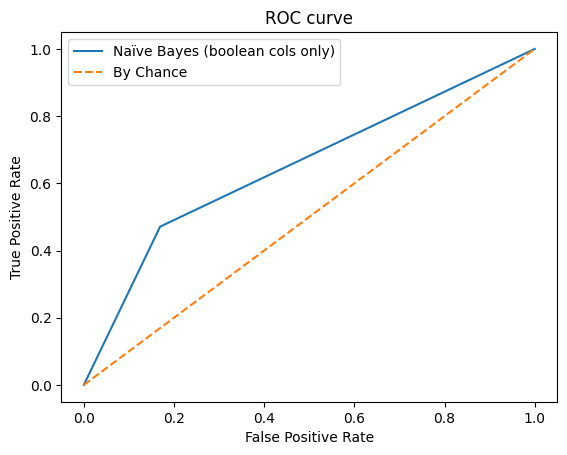

In [16]:
auc = make_ROC_curve(all_test_predictions, all_test_answers, "Naïve Bayes (boolean cols only)")

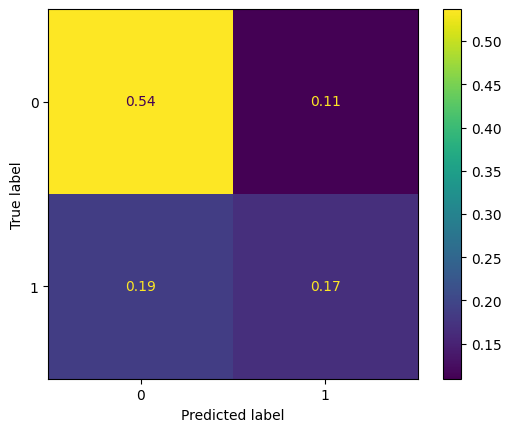

In [17]:
make_confusion_matrix(all_test_predictions, all_test_answers)

Our total proportion of correct predictions is (true positives) + (true negatives) = 0.54 + 0.16 = 0.70, and our AUC is 0.65, so not great. But we expected that. Let's use the **variance inflation factor** to find the multicollinear columns, get rid of the ones that are too multicollinear, and see what happens when we redo classical Naïve Bayes.

Since we want to avoid **data leakage**, we'll be recalculating the VIF for each K-fold and removing columns with a VIF above 5. We don't want to be making decisions about which columns to remove based on data we'll be testing on.

Let's now redo Naïve Bayes while removing the multicollinear columns.

In [18]:
test_results_dict, all_test_answers, all_test_predictions = classical_naive_bayes(data, remove_multicollinear_cols=True)

Area under ROC curve (AUC): 0.6535523473911561


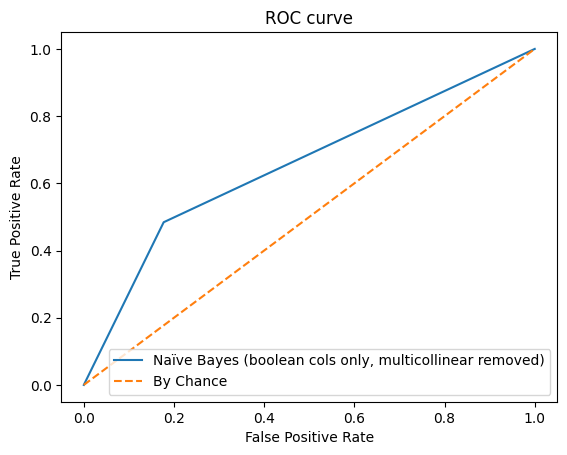

In [19]:
auc = make_ROC_curve(all_test_predictions, all_test_answers, "Naïve Bayes (boolean cols only, multicollinear removed)")

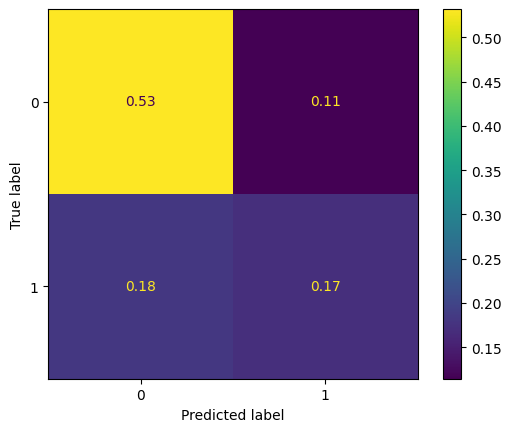

In [20]:
make_confusion_matrix(all_test_predictions, all_test_answers)

Okay, that didn't help at all. I'm not that surprised. With the way Naïve Bayes works, if we have columns that are highly multicollinear, we're almost multiplying by the same probabilities twice, so something previously classified as True is not suddenly going to have the False probability be higher after removing some columns. Let's look at Gaussian Naïve Bayes now.

# Gaussian Naïve Bayes

## Fitting Gaussians to the Uniform Distributions

We'll start by just fitting our uniform distributions with Gaussian ones, which will not go well, but let's see that for ourselves just to prove the point.

In [21]:
def implement_gaussian_bayes(data: pd.DataFrame, label_col: str="Diagnosis"):
    
    X = data.drop(columns=[label_col])
    y = data[label_col]
    
    bool_cols = X.dtypes[X.dtypes == bool].index
    gaussian_cols = X.dtypes[X.dtypes != bool].index
    
    unique_classes = y.unique()
    total_probabilities = y.value_counts() / len(y)
    
    all_means = pd.DataFrame(index = gaussian_cols, columns=unique_classes, dtype=float)
    all_standard_devs = pd.DataFrame(index = gaussian_cols, columns=unique_classes, dtype=float)
    
    all_means.columns.names = ["LabelValue"]
    all_standard_devs.columns.names = ["LabelValue"]
    
    for classification in unique_classes:
        this_df = data[data[label_col] == classification][gaussian_cols]
        all_means[classification] = this_df.mean()
        all_standard_devs[classification] = this_df.std()
        
    return all_means, all_standard_devs, gaussian_cols, unique_classes

In [22]:
all_means, all_standard_devs, gaussian_cols, unique_classes = implement_gaussian_bayes(data)

In [23]:
def test_gaussian_bayes(test_data: pd.DataFrame, all_means: pd.DataFrame, all_standard_devs: pd.DataFrame, gaussian_cols: list, unique_classes: list):

    test_data = test_data[gaussian_cols]
    all_gaussian_results = pd.DataFrame(index=test_data.index, columns=unique_classes)
    
    for classification in unique_classes:
        m = all_means[classification]
        s = all_standard_devs[classification]
        
        # Here, we're getting the likelihood of each test_data value using the means and standard deviations of each columns
        # We then sum across each row, which represents a different patient, since summing the logs
        # is the same as taking the log of the product of all likelihoods
        log_likelihood = np.sum(np.log(norm.pdf(test_data,m,s)), axis=1)
        all_gaussian_results[classification] = log_likelihood
    
    return all_gaussian_results

In [24]:
test_data = data.iloc[:10]
all_gaussian_results = test_gaussian_bayes(test_data, all_means, all_standard_devs, gaussian_cols, unique_classes)

## Transforming to Normal Distributions

Uniform distributions can be transformed to normal through the **Box-Muller transform**. Normally, this transform takes 2 independent uniform distributions and creates 2 independent normal distributions from them, but I've adapted it to just take 1 uniform distribution and spit out a normal distribution.

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html#sklearn.preprocessing.PowerTransformer

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html#sklearn.preprocessing.QuantileTransformer

In [25]:
def box_muller_transform(data_col: pd.Series, to_subtract: float=0.0) -> pd.Series:
    R = 2*np.log(data_col - to_subtract)
    theta = 2*np.pi*(data_col - to_subtract)
    
    x = R * np.sin(theta)
    return x

<Axes: >

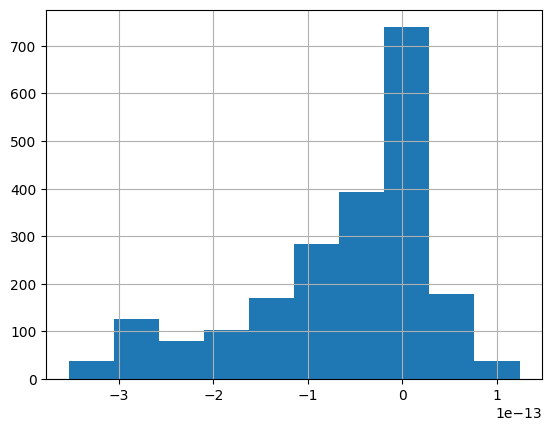

In [26]:
x = box_muller_transform(data["DiastolicBP"], 59)
x.hist()